In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from matplotlib import rcParams
from scipy.signal import find_peaks,savgol_filter

import utilities as ut
from pyfcd.fcd import calculate_carriers

THRESHOLD = 120
MAX_PIXEL_VALUE = 255
FRAME_PER_SECOND = 60
plt.style.use("default")
COLOR = 'black'

# FIGURE & AXES
rcParams['figure.figsize'] = (15,10)
rcParams['figure.dpi'] = 70
rcParams['axes.grid'] = True
# rcParams['axes.xmargin'] = 0
rcParams['axes.labelcolor'] = COLOR
rcParams['axes.facecolor'] = '#ebebeb'
rcParams['axes.grid.axis'] = 'both'
rcParams['axes.axisbelow'] = True
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR

# FONT
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['axes.titlesize'] = 36
rcParams['axes.labelsize'] = 36
rcParams['ytick.labelsize'] = 22
rcParams['xtick.labelsize'] = 22
rcParams['legend.fontsize'] = 28
rcParams['legend.title_fontsize'] = 28

rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

rcParams['savefig.bbox'] = 'tight'

In [23]:
#Definimos nuestros límites de observación
mask = [50,650,200,1100] # ymin, ymax, xmin, xmax

#Definimos nuestros px por mm obtenido de una calibración previa
PX_PER_MM = 4.856496282194044
FILEPATH= 'example_media/fcd/10Vpp-8Hz-wavedriver.mp4'
vs = cv.VideoCapture(f'{FILEPATH}')

#El algoritmo de FCD necesita de una imagen de referencia para obtener las deformaciones
#Esta funcion utiliza el primer frame y lo devuelve procesado
ref_frame = ut.load_ref_frame_and_try_mask(vs, mask)

Text(0, 0.5, 'z [px]')

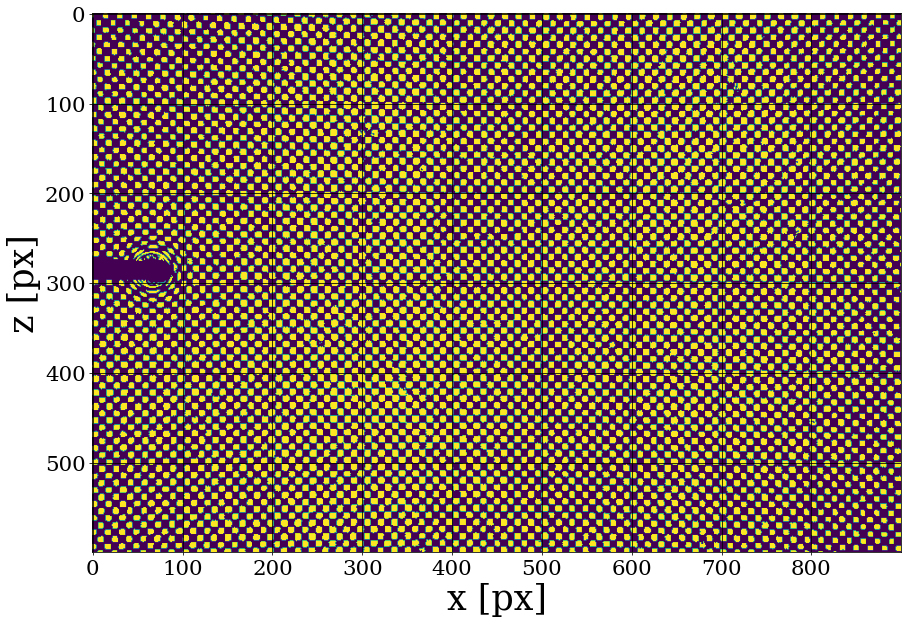

In [24]:
plt.imshow(ref_frame)
plt.xlabel('x [px]')
plt.ylabel('z [px]')

In [25]:
carriers = calculate_carriers(ref_frame, MM_PER_PX = (PX_PER_MM)**(-1))
vs = cv.VideoCapture(f'{FILEPATH}')
maps = ut.obtener_deformacion(vs, carriers, start=int(2*FRAME_PER_SECOND), finish = int(4*FRAME_PER_SECOND), SHOW=True, mask = mask)

X_LEN = maps[0].shape[1]
Z_LEN = maps[0].shape[0]

In [26]:
#Definimos límites de observación en x
min_x = 125
max_x = X_LEN

#Tomamos el punto medio
avg_x = (max_x + min_x)/2

#Elegimos el punto en z que coincide con el origen de nuestra perturbación
wave_point_z = Z_LEN//2
wave_point_x = int(avg_x)

# Ploteo de campo de deformación en la superficie

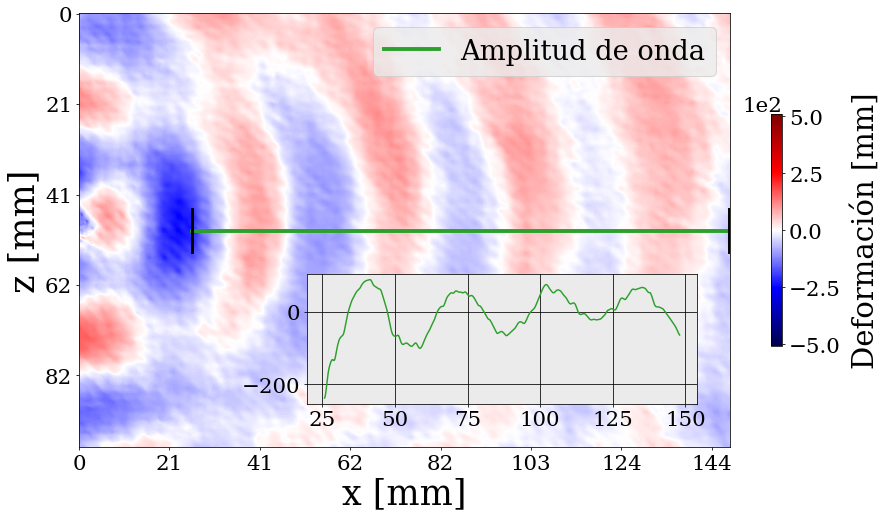

In [27]:
#Obtenemos nuestro colormap y norm
cmap, norm = ut.make_cmap_norm(maps)

#Definimos que frame queremos analizar
i_frame = 50

fig = plt.figure()
#Ploteamos la deformación
plt.imshow(maps[i_frame], aspect='equal', cmap=cmap, norm = norm)

#Configuramos el colorbar
cbar_term = plt.colorbar(pad=5e-2, shrink=0.43)
cbar_term.ax.ticklabel_format(axis='y',style='sci',scilimits=(0,2))
cbar_term.ax.set_ylabel('Deformación [mm]',labelpad=10, fontsize=30)

plt.ylabel('z [mm]')
plt.xlabel('x [mm]')
plt.xticks(ticks= plt.xticks()[0][1:-1], labels = [f'{i/PX_PER_MM:.0f}' for i in plt.xticks()[0][1:-1]])
plt.yticks(ticks= plt.yticks()[0][1:-1], labels = [f'{i/PX_PER_MM:.0f}' for i in plt.yticks()[0][1:-1]])
plt.xlim([0,X_LEN])
plt.grid()

#Opcional:
#Mostramos en el campo de deformación que región estamos observando
plt.axvline(min_x, ymin=0.45,ymax=0.55, color='k', lw=3,zorder=1)
plt.axvline(max_x-1,ymin=0.45,ymax=0.55, color='k', lw=3,zorder=1)
plt.axhline(Z_LEN//2,xmin=min_x/X_LEN,xmax=(max_x)/X_LEN, color='tab:green', lw=4, label='Amplitud de onda', zorder=0)

#Ploteamos el perfil de amplitud
axins = fig.axes[0].inset_axes([0.35, 0.1, 0.6, 0.3], xlim=(min_x,max_x), ylim=(wave_point_z+5,wave_point_z-5))
axins.clear()
axins.plot(np.arange(min_x,max_x)/PX_PER_MM, maps[i_frame][wave_point_z, min_x:max_x], color='tab:green')

plt.legend()

## Obtención de frecuencia principal de perturbación

Máximo interpolado en 8.0 Hz con un ancho a media altura de 0.6037349566168437 Hz


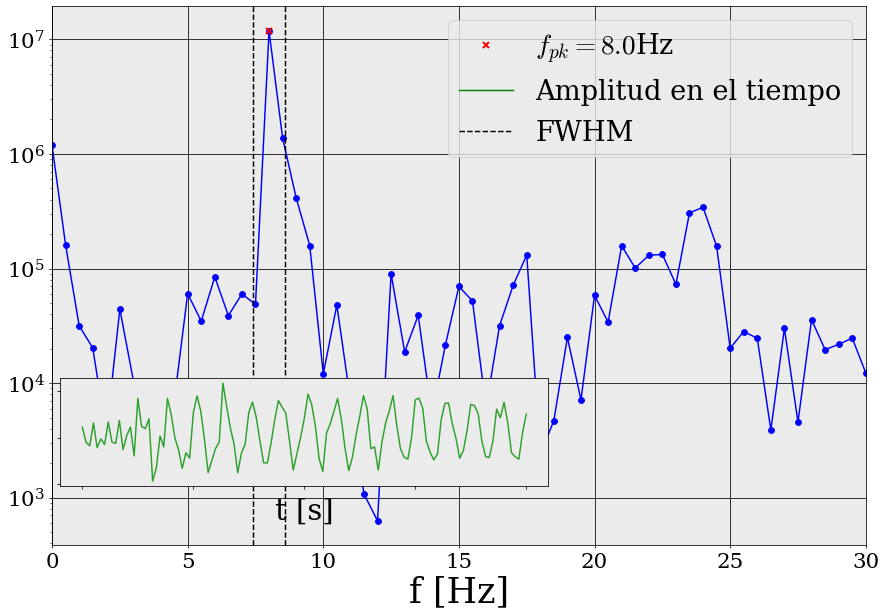

In [28]:
#Obtenemos la serie temporal de un punto en el espacio de nuestra interfase
wave_time = [frame[wave_point_z, wave_point_x] for frame in maps]

#Definimos nuestro array de frecuencias
fr = np.linspace(0, FRAME_PER_SECOND//2, len(wave_time)//2 + 1)

#Hacemos la transformada de fourier y obtenemos su pico máximo
wave_fft = np.abs(np.fft.rfft(wave_time))**2
peak_fft = find_peaks(wave_fft, height=5e6)[0]
max_peak_fft = np.argmax(wave_fft[peak_fft])
main_freq = fr[peak_fft[max_peak_fft]]

#Obtenemos el error de la frecuencia principal por medio de su ancho a media altura
fwhm = ut.get_fwhm(fr,wave_fft)

fig = plt.figure()

plt.plot(fr,wave_fft, 'o-', color='blue')
plt.plot(fr[peak_fft],wave_fft[peak_fft], 'x', color='r', markeredgewidth=2, label=f'$f_{{pk}} = {fr[peak_fft[max_peak_fft]]:.1f}$Hz')
plt.axvline(x=50,color='g',label='Amplitud en el tiempo')
plt.axvline(x=fr[peak_fft[max_peak_fft]] - fwhm , color='k', lw=1.5, ls='--')
plt.axvline(x=fr[peak_fft[max_peak_fft]] + fwhm , color='k', lw=1.5, ls='--',label='FWHM')

axins = fig.axes[0].inset_axes([0.01, 0.11, 0.6, 0.2], xticklabels=[], yticklabels=[])
axins.plot(np.arange(0,len(maps))/FRAME_PER_SECOND, wave_time, color='tab:green')
axins.set_xlabel('t [s]', fontsize=30)
axins.grid()

plt.xlabel('f [Hz]')
plt.semilogy()
plt.xlim([0,30])
plt.legend(loc='upper right')

## Obtención de la longitud de onda de nuestra perturbación

La longitud de onda del perfil de amplitud medido es 147.06 +- 3.233429093656408 px


Text(0, 0.5, 'y [mm]')

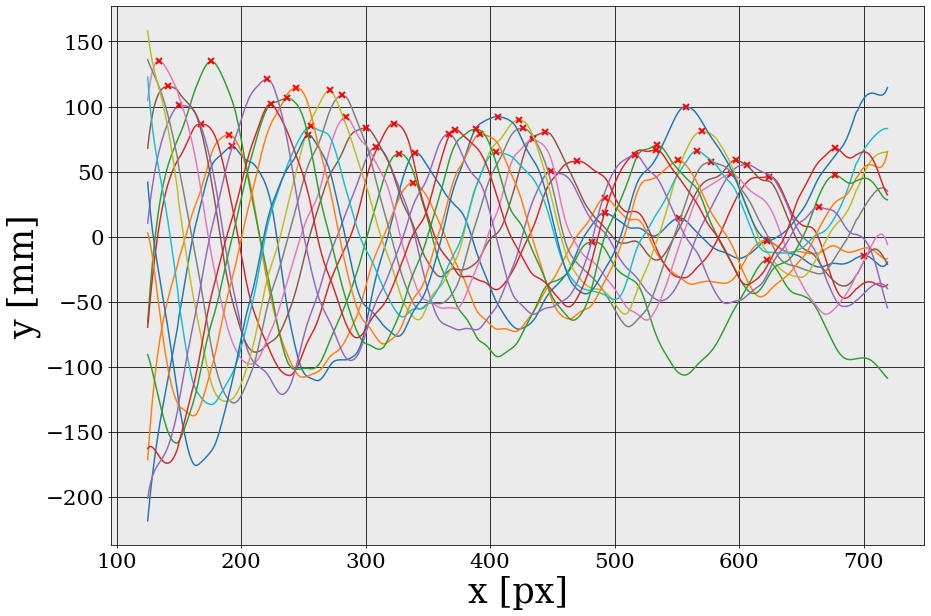

In [29]:
#Definimos la ventana de nuestro filtro savitsky-golay
n = 50
xs = np.arange(min_x,max_x)
wave_length = np.zeros(len(maps))

#Medimos la longitud de onda en un perfil de amplitud una vez por periodo.
#Hacemos esto porque es dificil configurar un find_peaks que funcione para todos los frames,
#pero mirando periodo a periodo los perfiles son todos similares
for i_frame in np.arange(len(maps) - 1)[20::int(main_freq**(-1)*FRAME_PER_SECOND)]:
    wave = maps[i_frame][wave_point_z, min_x:max_x]
    wave = savgol_filter(wave, n, polyorder=5)
    wave_peaks = find_peaks(wave, width=[15,250])[0]
    
    plt.plot(xs, wave)
    plt.plot(xs[wave_peaks], wave[wave_peaks], 'x', color='r', markeredgewidth=2)
    
    if len(wave_peaks)>1:
        wave_length[i_frame] = np.diff(xs[wave_peaks]).mean()

wavelength = np.mean(wave_length[wave_length!=0])
delta_wavelength = np.std(wave_length[wave_length!=0])/np.sqrt(len(wave_length[wave_length!=0]))

print("La longitud de onda del perfil de amplitud medido es {0} +- {1} px".format(wavelength, delta_wavelength))

plt.xlabel('x [px]')
plt.ylabel('y [mm]')